# Demonstrate examples for collaboration with novo nordisk

In [1]:
from data_causl.utils import *
from data_causl.data import *
from frengression import *

device = torch.device('cpu')
from CausalEGM import *

import numpy as np
import pickle
import os
from tqdm import tqdm
import src.exp_utils as exp_utils
import torch.nn as nn

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import log_loss
from scipy.spatial.distance import pdist, squareform
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Helper function for MMD
def mmd_rbf(x, y, sigma=1.0):
    """Compute MMD between two distributions using RBF kernel."""
    pairwise_sq_dists = squareform(pdist(np.vstack([x, y]), 'sqeuclidean'))
    K = np.exp(-pairwise_sq_dists / (2 * sigma ** 2))
    K_xx = K[:len(x), :len(x)]
    K_xy = K[:len(x), len(x):]
    K_yy = K[len(x):, len(x):]
    mmd = np.mean(K_xx) - 2 * np.mean(K_xy) + np.mean(K_yy)
    return mmd


np.random.seed(42)

nI = 2
nX = 2
nO = 2
nS= 2
p = nI+nX+nO+nS
ate = 4
beta_cov = 0
strength_instr = 0
strength_conf = 0
strength_outcome = 0
binary_intervention=True

In [2]:
df_tr = generate_data_causl(n=1000, nI =nI, nX= nX, nO = nO, nS = nS, ate = ate, beta_cov = beta_cov, strength_instr = strength_instr, strength_conf = strength_conf, strength_outcome =strength_outcome, binary_intervention=binary_intervention)
z_tr = torch.tensor(df_tr[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
x_tr = torch.tensor(df_tr['A'].values, dtype=torch.int32).view(-1, 1)
y_tr = torch.tensor(df_tr['y'].values, dtype=torch.float32).view(-1, 1)

## specify causal margin

In [3]:
np.random.seed(42)
model = Frengression(x_tr.shape[1], y_tr.shape[1], z_tr.shape[1], noise_dim=1, num_layer=3, hidden_dim=100, device=device, x_binary = binary_intervention)
model.train_xz(x_tr, z_tr, num_iters=1000, lr=1e-4, print_every_iter=200)
model.train_y(x_tr, z_tr, y_tr, num_iters=1000, lr=1e-4, print_every_iter=200)

Epoch 1: loss 2.6811, loss1 2.8254, loss2 0.2885
Epoch 200: loss 2.1666, loss1 3.1569, loss2 1.9806
Epoch 400: loss 2.0115, loss1 3.7452, loss2 3.4673
Epoch 600: loss 2.0172, loss1 3.8908, loss2 3.7471
Epoch 800: loss 1.9941, loss1 3.9308, loss2 3.8733
Epoch 1000: loss 2.0204, loss1 3.9202, loss2 3.7994
Epoch 1: loss 3.1140,	loss_y 2.3732, 2.3968, 0.0473,	loss_eta 0.7408, 0.7700, 0.0586
Epoch 200: loss 1.9125,	loss_y 1.3358, 1.6956, 0.7198,	loss_eta 0.5768, 1.0421, 0.9307
Epoch 400: loss 1.1687,	loss_y 0.6084, 1.1656, 1.1144,	loss_eta 0.5603, 1.1174, 1.1141
Epoch 600: loss 1.0711,	loss_y 0.5516, 1.1357, 1.1682,	loss_eta 0.5195, 1.0907, 1.1425
Epoch 800: loss 1.1503,	loss_y 0.5782, 1.1739, 1.1914,	loss_eta 0.5721, 1.1279, 1.1116
Epoch 1000: loss 1.1450,	loss_y 0.5741, 1.1406, 1.1330,	loss_eta 0.5709, 1.1095, 1.0773


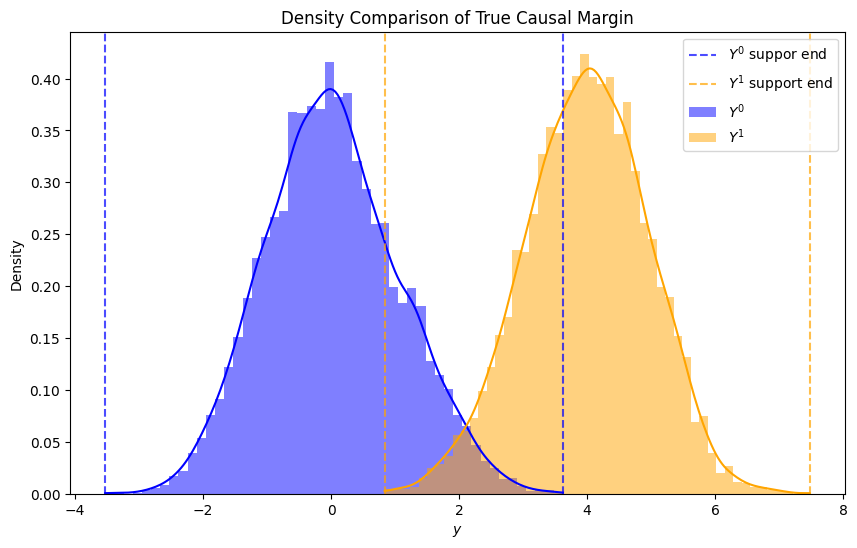

In [4]:
# Sample causal margins
x0_samples = model.sample_causal_margin(x=torch.tensor([[0]], dtype=torch.int32), sample_size=6000).numpy().flatten()
x1_samples = model.sample_causal_margin(x=torch.tensor([[1]], dtype=torch.int32), sample_size=6000).numpy().flatten()

# Plot histograms and KDE
plt.figure(figsize=(10, 6))

# Histogram for x0_samples
sns.histplot(x0_samples, kde=True, color='blue', label='$Y^0$', stat="density", bins=50, edgecolor=None, alpha=0.5)

# Histogram for x1_samples
sns.histplot(x1_samples, kde=True, color='orange', label='$Y^1$', stat="density", bins=50, edgecolor=None, alpha=0.5)

# Highlight different supports (if needed)
plt.axvline(min(x0_samples), color='blue', linestyle='--', alpha=0.7, label='$Y^0$ suppor end')
plt.axvline(max(x0_samples), color='blue', linestyle='--', alpha=0.7)
plt.axvline(min(x1_samples), color='orange', linestyle='--', alpha=0.7, label='$Y^1$ support end')
plt.axvline(max(x1_samples), color='orange', linestyle='--', alpha=0.7)

# Add labels, legend, and title
plt.xlabel("$y$")
plt.ylabel("Density")
plt.title("Density Comparison of True Causal Margin")
plt.legend()
plt.show()


In [5]:
sampled_x,sampled_y,sampled_z = model.sample_joint(sample_size=6000)
print('Diff-in-means: ', sampled_y[sampled_x==1].mean()-sampled_y[sampled_x==0].mean())
print('Proportion of sampled treated: ', (sampled_x==1).sum()/sampled_x.shape[0])
print('Proportion of true treated: ', (x_tr==1).sum()/x_tr.shape[0])

Diff-in-means:  tensor(3.9668)
Proportion of sampled treated:  tensor(0.4727)
Proportion of true treated:  tensor(0.4960)


In [6]:
class SpecifiedCausalMargin(nn.Module):
    def __init__(self, ate,x_dim):
        super().__init__()
        self.ate = ate  # or self.register_buffer('eta', torch.tensor(eta))
        self.x_dim = x_dim

    def forward(self, x_eta):
        # If 'eta' is truly separate, might need to handle that carefully
        x = x_eta[:, :self.x_dim]
        eta = x_eta[:, self.x_dim:]
        return self.ate * x + eta


In [7]:
margin_module = SpecifiedCausalMargin(ate=5, x_dim = x_tr.shape[1])
model.specify_causal(causal_margin=margin_module)

sampled_x,sampled_y,sampled_z = model.sample_joint(sample_size=10000)
print('Diff-in-means: ', sampled_y[sampled_x==1].mean()-sampled_y[sampled_x==0].mean())
print('Proportion of sampled treated: ', (sampled_x==1).sum()/sampled_x.shape[0])
print('Proportion of true treated: ', (x_tr==1).sum()/x_tr.shape[0])

Diff-in-means:  tensor(5.0025)
Proportion of sampled treated:  tensor(0.4678)
Proportion of true treated:  tensor(0.4960)


In [8]:
margin_module = SpecifiedCausalMargin(ate=0, x_dim = x_tr.shape[1])
model.specify_causal(causal_margin=margin_module)

sampled_x,sampled_y,sampled_z = model.sample_joint(sample_size=50000)
print('Diff-in-means: ', sampled_y[sampled_x==1].mean()-sampled_y[sampled_x==0].mean())
print('Proportion of sampled treated: ', (sampled_x==1).sum()/sampled_x.shape[0])
print('Proportion of true treated: ', (x_tr==1).sum()/x_tr.shape[0])

Diff-in-means:  tensor(-0.0069)
Proportion of sampled treated:  tensor(0.4624)
Proportion of true treated:  tensor(0.4960)
